In [15]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, PolynomialFeatures,
    OrdinalEncoder, RobustScaler, PowerTransformer
)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
# Suppress all warnings for clean output
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)

In [16]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (59611, 24)
Test shape: (14900, 23)


In [17]:
# Define column types based on your earlier analysis
id_col = 'founder_id'
target = 'retention_status'

# Define the order for ordinal features (MUST be defined early for pipelines)
ordinal_cols_map = {
    'work_life_balance_rating': ['Poor', 'Fair', 'Good', 'Excellent'],
    'venture_satisfaction': ['Low', 'Medium', 'High', 'Very High'],
    'startup_performance_rating': ['Low', 'Below Average', 'Average', 'High'],
    'startup_reputation': ['Poor', 'Fair', 'Good', 'Excellent'],
    'founder_visibility': ['Low', 'Medium', 'High', 'Very High'],
    'startup_stage': ['Entry', 'Mid', 'Senior'],
    'team_size_category': ['Small', 'Medium', 'Large']
}
ordinal_feature_names = list(ordinal_cols_map.keys())
ordinal_categories = list(ordinal_cols_map.values())

nominal_cols = ['founder_gender', 'founder_role', 'education_background', 'personal_status']
binary_cols = ['working_overtime', 'remote_operations', 'leadership_scope', 'innovation_support']
initial_num_cols = [
    'monthly_revenue_generated', 'num_dependents', 'years_since_founding',
    'founder_age', 'years_with_startup', 'funding_rounds_led',
    'distance_from_investor_hub'
]

numerical_cols = initial_num_cols 
all_cat_cols = binary_cols + ordinal_feature_names + nominal_cols

In [18]:
# --- Convert target to numeric for correlation/modeling early ---
train[target] = train[target].map({'Stayed': 1, 'Left': 0}).astype(int)

In [19]:
# Check for duplicates and drop them (reusing your logic)
dup_count = train.duplicated().sum()
if dup_count > 0:
    train.drop_duplicates(inplace=True)
    print(f"Duplicates removed. New train shape: {train.shape}")

Duplicates removed. New train shape: (59598, 24)



--- Target Distribution ---


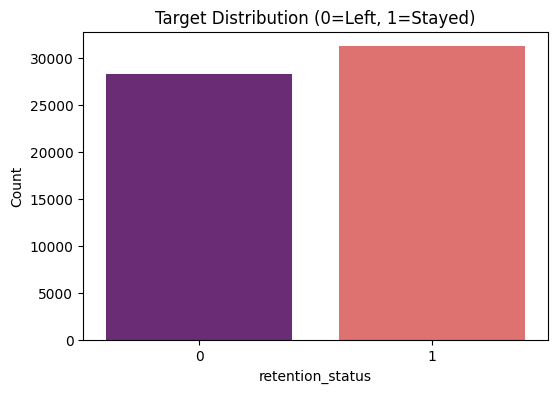

retention_status
1    0.524514
0    0.475486
Name: proportion, dtype: float64


In [20]:
# 2a. Target Distribution
print("\n--- Target Distribution ---")
plt.figure(figsize=(6, 4))
sns.countplot(x=target, hue=target, data=train, palette='magma', legend=False)
plt.title(f'Target Distribution (0=Left, 1=Stayed)')
plt.ylabel('Count')
plt.show()
print(train[target].value_counts(normalize=True))


--- Missing Value Analysis ---
                           Missing Percentage
work_life_balance_rating             0.169989
venture_satisfaction                 0.119987
num_dependents                       0.079986
years_since_founding                 0.069986
team_size_category                   0.049985
monthly_revenue_generated            0.029984


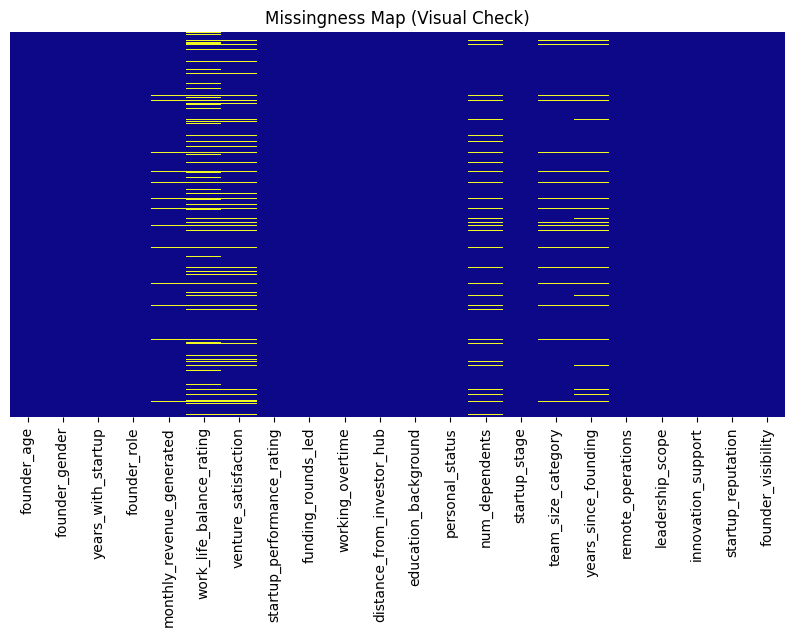

In [21]:
# 2b. Missing Value Analysis (Visual and Tabular)
print("\n--- Missing Value Analysis ---")
missing_pct = train.isnull().mean().sort_values(ascending=False)
missing_df = pd.DataFrame({'Missing Percentage': missing_pct[missing_pct > 0]})
print(missing_df)

plt.figure(figsize=(10, 5))
sns.heatmap(train.drop(columns=[id_col, target]).isnull(), cbar=False, yticklabels=False, cmap='plasma')
plt.title('Missingness Map (Visual Check)')
plt.show()


--- Numerical Feature Distributions and Skew ---


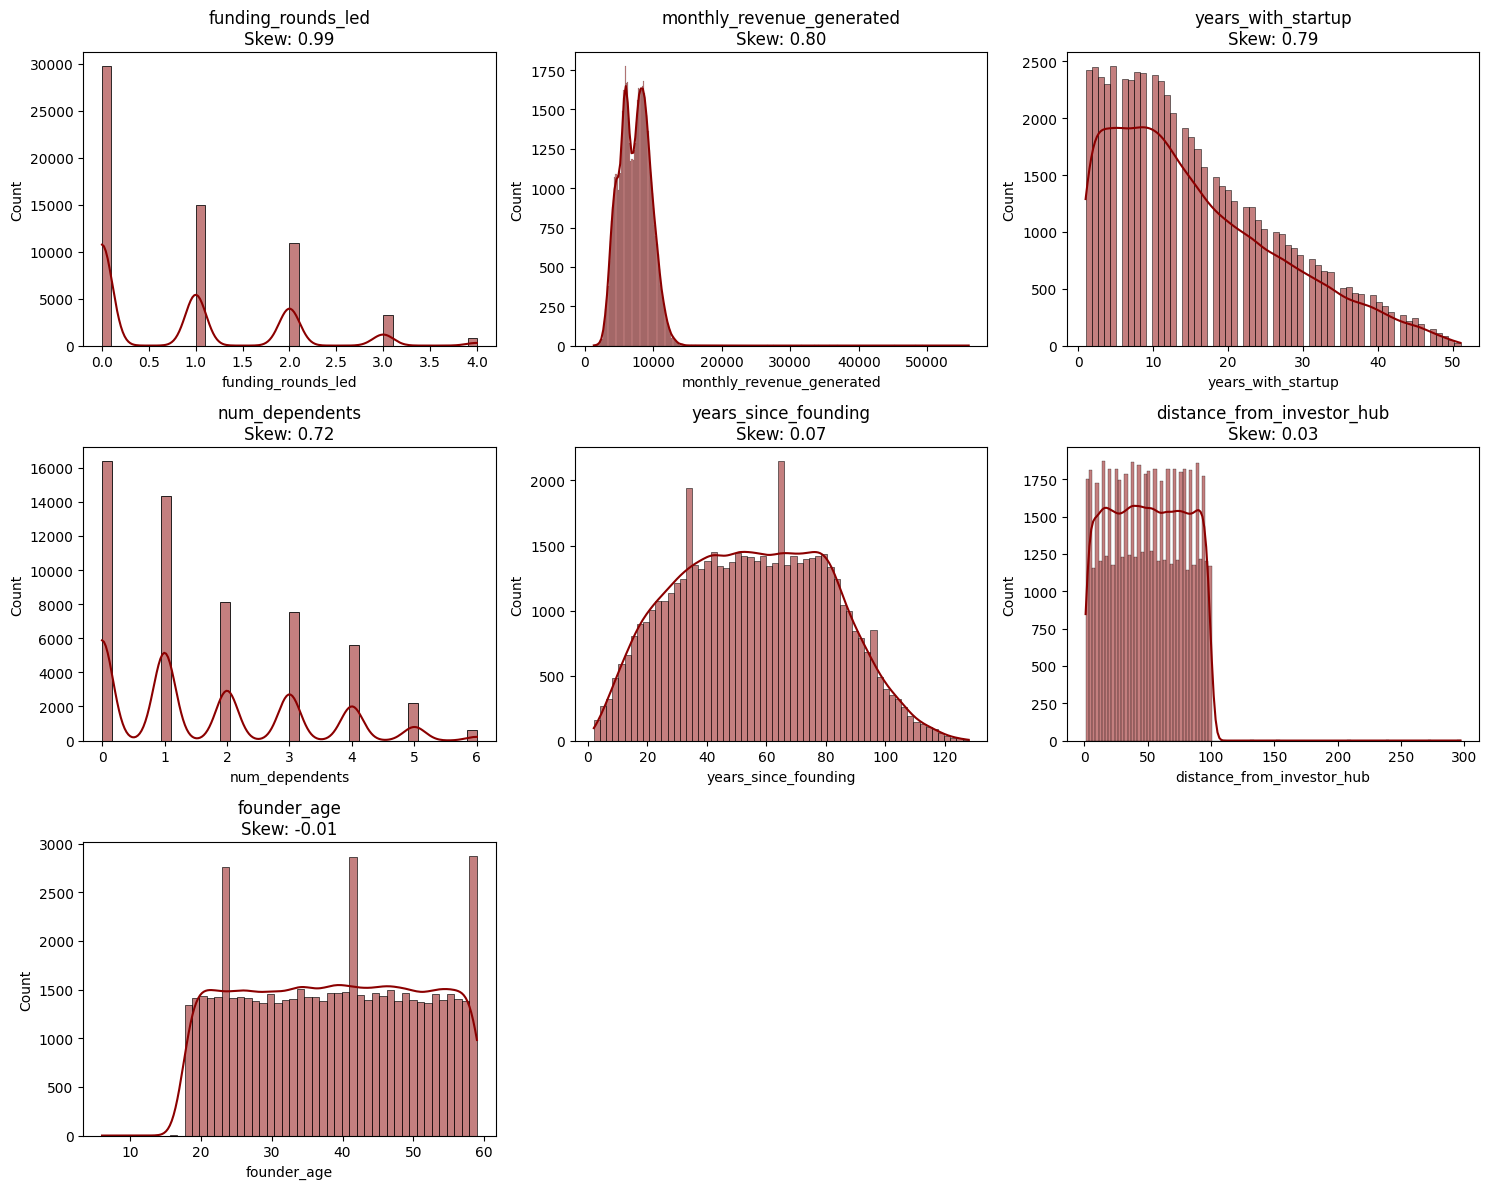

In [22]:
# 2c. Feature Distribution Check (Histograms & Skew)
print("\n--- Numerical Feature Distributions and Skew ---")
plt.figure(figsize=(15, 12))
skew_values = train[numerical_cols].skew().sort_values(ascending=False)
# Plot top 8 skewed numerical features
for i, col in enumerate(skew_values.index.tolist()[:8], 1):
    plt.subplot(3, 3, i)
    sns.histplot(train[col].dropna(), kde=True, bins='auto', color='darkred')
    plt.title(f'{col}\nSkew: {skew_values[col]:.2f}', fontsize=12)
plt.tight_layout()
plt.show()


--- Numerical Feature Correlation ---


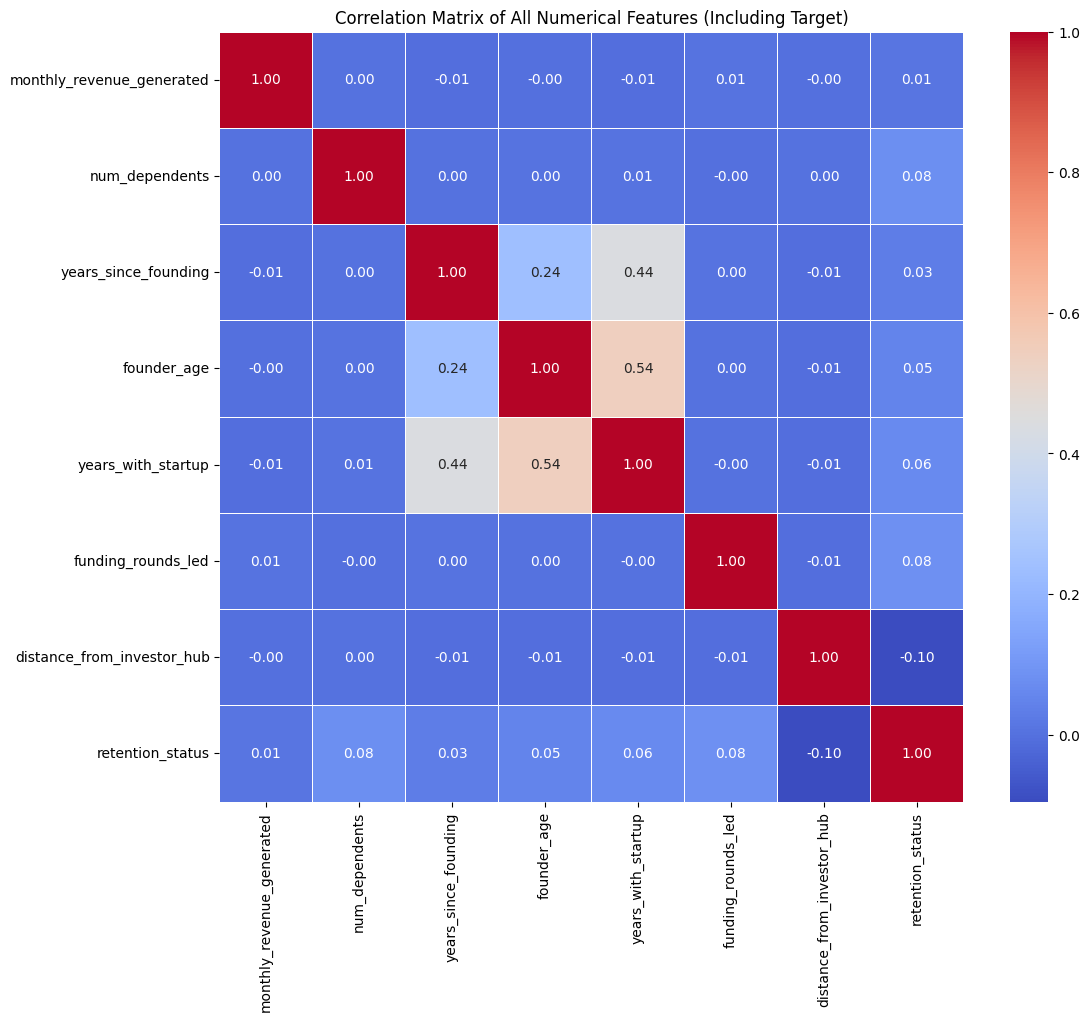

In [23]:
# 2d. Correlation of all numerical features
print("\n--- Numerical Feature Correlation ---")
all_num_features = numerical_cols + [target]
plt.figure(figsize=(12, 10))
sns.heatmap(train[all_num_features].corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of All Numerical Features (Including Target)')
plt.show()

In [24]:
# 2e. Chi-Square Test for Categorical Significance
print("\n--- Chi-Square Test for Categorical Significance ---")
all_cat_cols = binary_cols + ordinal_feature_names + nominal_cols
print(f"{'Feature':<30} | {'P-Value':<10} | {'Conclusion'}")
print("-" * 55)
for col in all_cat_cols:
    contingency_table = pd.crosstab(train[col].astype(str).fillna('Missing'), train[target])
    try:
        if (contingency_table.sum(axis=1) > 0).all() and (contingency_table.sum(axis=0) > 0).all():
            chi2, p, _, _ = chi2_contingency(contingency_table)
            conclusion = "Significant (KEEP)" if p < 0.05 else "Not Significant"
            print(f"{col:<30} | {p:.5f}      | {conclusion}")
        else:
            print(f"{col:<30} | N/A        | Skipped (Zero marginals)")
    except ValueError:
        print(f"{col:<30} | N/A        | Skipped (Error)")


--- Chi-Square Test for Categorical Significance ---
Feature                        | P-Value    | Conclusion
-------------------------------------------------------
working_overtime               | 0.00000      | Significant (KEEP)
remote_operations              | 0.00000      | Significant (KEEP)
leadership_scope               | 0.01353      | Significant (KEEP)
innovation_support             | 0.00000      | Significant (KEEP)
work_life_balance_rating       | 0.00000      | Significant (KEEP)
venture_satisfaction           | 0.00000      | Significant (KEEP)
startup_performance_rating     | 0.00000      | Significant (KEEP)
startup_reputation             | 0.00000      | Significant (KEEP)
founder_visibility             | 0.25073      | Not Significant
startup_stage                  | 0.00000      | Significant (KEEP)
team_size_category             | 0.00000      | Significant (KEEP)
founder_gender                 | 0.00000      | Significant (KEEP)
founder_role                   |

In [25]:
## 3. Advanced Feature Engineering (Applied to both datasets)

print("\n--- Feature Engineering ---")
for df in [train, test]:
    # 1. Experience Ratios (Your previous features, robustly handled)
    df['experience_ratio'] = df['years_with_startup'] / (df['years_since_founding'].fillna(df['years_since_founding'].median()) + np.finfo(float).eps)
    df['founder_join_age'] = df['founder_age'] - df['years_with_startup']
    df['revenue_per_round'] = df['monthly_revenue_generated'] / (df['funding_rounds_led'] + 1)

    # 2. New Interaction/Ratio Features (Inspired by friend's script)
    df['revenue_per_year'] = df['monthly_revenue_generated'] / (df['years_since_founding'].fillna(df['years_since_founding'].median()) + 1)
    df['life_investment_ratio'] = df['years_with_startup'] / (df['founder_age'] + 1)
    df['age_at_founding'] = df['founder_age'] - df['years_with_startup']

# Add new engineered numerical features to the list
engineered_num_cols = ['experience_ratio', 'founder_join_age', 'revenue_per_round', 
                       'revenue_per_year', 'life_investment_ratio', 'age_at_founding']
numerical_cols = initial_num_cols + engineered_num_cols
print(f"Total Numerical Features: {len(numerical_cols)}")


--- Feature Engineering ---
Total Numerical Features: 13


In [26]:
## 4. Outlier Handling (Before Splitting)

print("\n--- Outlier and Skew Handling ---")
# Log transform for highly skewed revenue (common in financial features)
train['monthly_revenue_generated'] = np.log1p(train['monthly_revenue_generated'])
test['monthly_revenue_generated'] = np.log1p(test['monthly_revenue_generated'])

# Capping extreme outliers (inspired by friend's script)
for col in ['founder_age', 'years_with_startup', 'years_since_founding']:
    upper_bound = train[col].quantile(0.99)
    train[col] = train[col].clip(upper=upper_bound)
    test[col] = test[col].clip(upper=upper_bound)


--- Outlier and Skew Handling ---


In [27]:
# Separate Features (X) and Target (y)
X = train.drop(columns=[target, id_col])
y = train[target]
X_test_final = test.drop(columns=[id_col])

# Split the Data (80% Train, 20% Test, stratified)
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTraining set shape: {X_train.shape}, Validation set shape: {X_test_val.shape}")


Training set shape: (47678, 28), Validation set shape: (11920, 28)


In [28]:
## Define Preprocessing Pipelines

# 1. Numerical Pipeline: Impute -> Normalize Skew -> Scale
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handle NaNs
    ('power_transform', PowerTransformer(method='yeo-johnson')), # Handle remaining skewness/make distribution more Gaussian
    ('scaler', RobustScaler()) # Scale robustly to remaining outliers
])

# 2. Binary Pipeline: Impute -> Map to 0/1
binary_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('mapper', OrdinalEncoder(categories=[['No', 'Yes']] * len(binary_cols)))
])

# 3. Ordinal Pipeline: Impute -> Encode
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=ordinal_categories))
])

# 4. Nominal Pipeline: Impute -> One-Hot Encode (Dropping first to avoid multicollinearity)
nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

# Combine all transformations into a ColumnTransformer 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('bin', binary_pipeline, binary_cols),
        ('ord', ordinal_pipeline, ordinal_feature_names),
        ('nom', nominal_pipeline, nominal_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False # Ensures clean feature names
).set_output(transform='pandas') # Output directly as a DataFrame

print("\n--- ColumnTransformer Preprocessor Defined ---")


--- ColumnTransformer Preprocessor Defined ---


In [29]:
# Fit and Transform Data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_val_processed = preprocessor.transform(X_test_val)
X_test_final_processed = preprocessor.transform(X_test_final)

print("\n--- Final Processed Data Shapes ---")
print(f"X_train (ready for model): {X_train_processed.shape}")
print(f"X_test_val (ready for evaluation): {X_test_val_processed.shape}")
print(f"X_test_final (ready for submission prediction): {X_test_final_processed.shape}")

print("\nProcessed Training Data Head:")
print(X_train_processed.head())


--- Final Processed Data Shapes ---
X_train (ready for model): (47678, 35)
X_test_val (ready for evaluation): (11920, 35)
X_test_final (ready for submission prediction): (14900, 35)

Processed Training Data Head:
       monthly_revenue_generated  num_dependents  years_since_founding  \
1991                   -1.153828        0.653539              0.343699   
1402                   -0.976657        0.000000              0.000000   
39765                   0.773724        0.495738              1.174343   
43544                  -0.783684        0.781831              0.473052   
45355                  -0.983118        0.291013              0.160050   

       founder_age  years_with_startup  funding_rounds_led  \
1991      0.768480            1.101992           -0.500000   
1402     -0.591439           -1.104328           -0.500000   
39765     0.549101            1.036110            1.099485   
43544     0.233080            0.822669           -0.500000   
45355    -0.289334            0